# **Predicting Market Prices Using LSTM and Sentiment Analysis**

## **Introduction**

Predicting market prices has always been a challenging yet highly rewarding endeavor in the financial domain. This project explores this challenge by leveraging the power of **machine learning**—specifically, a **Long Short-Term Memory (LSTM)** network—to forecast market prices. The model integrates **sentiment analysis** as a core feature to capture the psychological and behavioral factors that drive market movements.

---

## **Motivation**
Financial markets are not only influenced by traditional metrics such as supply and demand, earnings reports, and macroeconomic indicators but are also significantly impacted by the **sentiments of investors**. News articles, social media posts, and public sentiment play a critical role in shaping market trends. Traditional time-series models often fail to incorporate this rich layer of information, which is why this project integrates **sentiment analysis** into price prediction.

---

## **Objectives**
The primary objectives of this project are:
1. **Develop a predictive model** leveraging both **historical price data** and **market sentiment** to enhance price forecasting accuracy.
2. Evaluate whether incorporating sentiment analysis provides a competitive edge over traditional models.
3. Explore the **applicability of the model** in actionable trading strategies.

---

## **Methodology**

### **1. Data Collection**
This project combines two key datasets:
- **Market Price Data**: Historical price data, including open, high, low, close prices, and trading volume.
- **Sentiment Data**: Extracted from financial news articles, social media posts, and other text-based sources. Sentiment scores were derived using **Natural Language Processing (NLP)** techniques.

### **2. Sentiment Analysis**
- **Text Preprocessing**: News headlines and posts were cleaned and tokenized to remove noise.
- **Sentiment Scoring**: Sentiment scores were calculated using pre-trained models like **VADER** or **FinBERT**, fine-tuned for financial text.
- **Feature Engineering**: Aggregated sentiment scores over time windows aligned with price data frequency.

### **3. Model Selection**
- Utilized an **LSTM network**, a form of **Recurrent Neural Network (RNN)**, to capture long-term dependencies in sequential data.
- LSTMs excel at handling the temporal dependencies and non-linearities inherent in market dynamics.

### **4. Model Architecture**
- **Inputs**: Combined **numerical features** (historical prices, trading volume) and **sentiment scores**.
- **Hidden Layers**: LSTM layers captured sequential dependencies, followed by fully connected layers for regression.
- **Output**: Predicted next-day price or directional movement.

### **5. Training and Evaluation**
- Split the dataset into **training**, **validation**, and **test sets**, ensuring no data leakage.
- Optimized using **Mean Squared Error (MSE)** and evaluated with **R² (Coefficient of Determination)**.
- Performed **hyperparameter tuning** to refine learning rates, number of LSTM layers, and units.


# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score
from torch.optim.lr_scheduler import OneCycleLR
from transformers import AutoTokenizer, AutoModelForSequenceClassification
# From skfin
from sklearn.feature_extraction.text import CountVectorizer

c:\Users\mcgpr\anaconda3\envs\skfin\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Utils

In [3]:
def sequencing(df, companies, sequence_length, include_news=False):
    data = []
    for company in companies:
        if include_news:
            if 'neutral' in df.columns:
                company_data = df[df['Company'] == company][['Close', 'negative', 'neutral', 'positive']].values
            else:
                company_data = df[df['Company'] == company][['Close', 'negative', 'positive']].values
            for i in range(company_data.shape[0]):
                sentiment_values = company_data[i, 1:]
                max_index = np.argmax(sentiment_values)
                binary_sentiment = np.zeros_like(sentiment_values)
                binary_sentiment[max_index] = 1
                company_data[i, 1:] = binary_sentiment
            data.append(company_data)
        else:
            company_data = df[df['Company'] == company][['Close']].values
            data.append(company_data)
    sequenced_data = []
    for d in data:
        if d.shape[0] <= sequence_length:
            print(d.shape)
            continue
        for k in range(d.shape[0] - sequence_length):
            sequence = d[k:k + sequence_length, :]
            sequenced_data.append(sequence)
    sequenced_data = np.array(sequenced_data)
    return sequenced_data

In [4]:
def evaluate_model(model, data_loader):
    model.eval()
    predictions = []
    targets = []
    test_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            # Move data to device
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            # Model inference
            outputs = model(x_batch)
            
            # Detach and move to CPU
            preds = outputs.squeeze().cpu().numpy()  # Shape: (batch_size,)
            true_values = y_batch.cpu().numpy()      # Shape: (batch_size,)
            loss = criterion(test_outputs.squeeze(), y_test)
            test_loss += loss.item()
            # Collect predictions and targets
            predictions.extend(preds)
            targets.extend(true_values)
    # Reshape to 2D arrays (scaler expects 2D inputs)
    predictions = np.array(predictions).reshape(-1, 1)
    targets = np.array(targets).reshape(-1, 1)

    scaler = scalers[0]
    # Apply inverse transform
    predictions = scaler.inverse_transform(predictions)
    targets = scaler.inverse_transform(targets)
    return predictions.flatten(), targets.flatten(), test_loss/len(test_loader)

In [5]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = self.data[idx, :-1, :]
        y = self.data[idx, -1, 0]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [6]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, seed=42):
        super(LSTM, self).__init__()
        
        # Linear layer at the beginning
        self.initial_linear = nn.Linear(input_dim, input_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.seed = seed
        self.init_weights()
    
    def forward(self, x):
        # Pass through the initial linear layer
        x = self.initial_linear(x)
        
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out
    
    def init_weights(self):
        torch.manual_seed(self.seed)
        
        # Initialize weights for the initial linear layer
        nn.init.xavier_uniform_(self.initial_linear.weight.data)
        nn.init.constant_(self.initial_linear.bias.data, 0)

        # Initialize weights for the LSTM layer
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                nn.init.constant_(param.data, 0)

        # Initialize weights for the fully connected layer
        nn.init.xavier_uniform_(self.fc.weight.data)
        nn.init.constant_(self.fc.bias.data, 0)

In [7]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=True, min_delta=1e-4, save_path="best_model.pth"):
        self.patience = patience
        self.verbose = verbose
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.save_path = save_path

    def __call__(self, val_loss, model):
            if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
                # New best loss found, save the model
                self.best_loss = val_loss
                self.counter = 0
                torch.save(model.state_dict(), self.save_path)
                if self.verbose:
                    print(f"Validation loss improved. Model saved to {self.save_path}")
            else:
                # No improvement, increment counter
                self.counter += 1
                if self.verbose:
                    print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
                if self.counter >= self.patience:
                    self.early_stop = True
                    print("Early stopping triggered.")

# Feeding Price without sentiment as inputs

## Preprocessing

### Data processing

In [8]:
num_companies = 10

In [9]:
prices = pd.read_csv('data/sp500_prices.csv')
prices['date'] = pd.to_datetime(prices['Date'])
prices = prices.drop(columns=['Date'])
prices.sort_values(by='date', ascending=True, inplace=True)

In [10]:
dates = prices['date'].drop_duplicates().values
split_date = dates[int(0.8 * len(dates))]

train = prices[prices['date'] <= split_date]
val = prices[prices['date'] > split_date]
num_val_dates = len(val['date'].drop_duplicates().values)

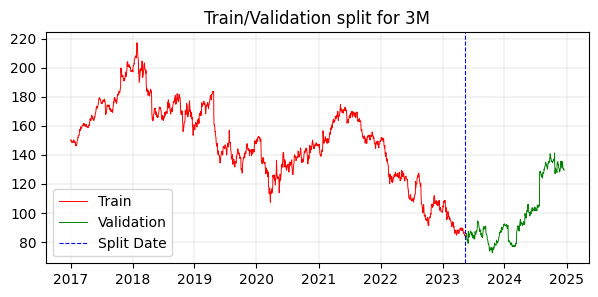

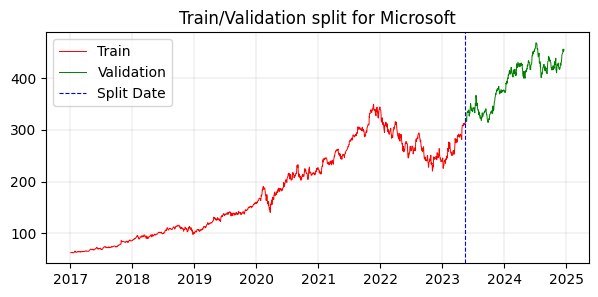

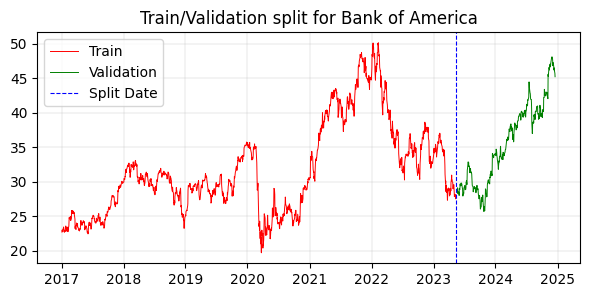

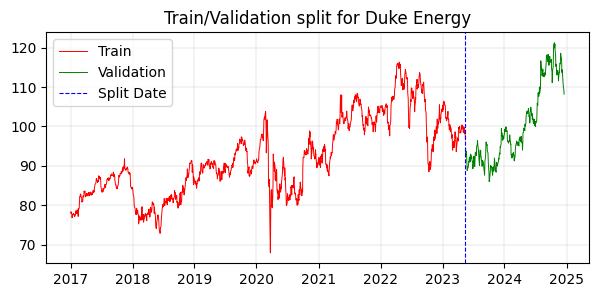

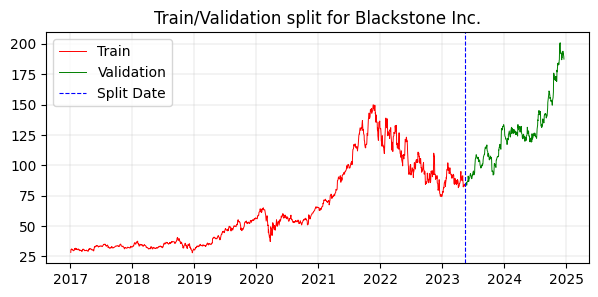

In [11]:
companies = prices['Company'].drop_duplicates().values
for company in companies[:5]:
    train_ex = train[train['Company'] == company]['High'].values
    train_dates = train['date'].drop_duplicates().values
    val_ex = val[val['Company'] == company]['High'].values
    val_dates = val['date'].drop_duplicates().values

    plt.figure(figsize=(7, 3))
    plt.grid(linewidth=0.2)
    plt.plot(train_dates, train_ex, linewidth=0.7, label='Train', c='r')
    plt.plot(val_dates, val_ex, linewidth=0.7, label='Validation', c='g')
    plt.axvline(x=split_date, color='b', linestyle='--', linewidth=0.8, label='Split Date')
    plt.legend()
    plt.title(f'Train/Validation split for {company}')
plt.show()

### Data Augmentation

In [12]:
train_sequence = sequencing(train, companies[:num_companies], 100)
val_sequence = sequencing(val, companies[:num_companies], num_val_dates-1)

print(f'sequenced train data: {train_sequence.shape}')
print(f'sequenced validation data: {val_sequence.shape}')

sequenced train data: (15030, 100, 1)
sequenced validation data: (10, 399, 1)


## Training

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_data, test_data = train_test_split(train_sequence, test_size=0.2, random_state=42, shuffle=True)
train_data = np.array(train_data)
test_data = np.array(test_data)

num_features = train_data.shape[2]  # Number of features
scalers = [MinMaxScaler(feature_range=(0, 1)) for _ in range(num_features)]

train_data_scaled = np.zeros_like(train_data)
test_data_scaled = np.zeros_like(test_data)

for feature_idx in range(num_features):
    train_feature = train_data[:, :, feature_idx].reshape(-1, 1)  # Shape: (num_samples * seq_len, 1)
    test_feature = test_data[:, :, feature_idx].reshape(-1, 1)
    
    scalers[feature_idx].fit(train_feature)
    
    train_data_scaled[:, :, feature_idx] = scalers[feature_idx].transform(train_feature).reshape(train_data.shape[0], -1)
    test_data_scaled[:, :, feature_idx] = scalers[feature_idx].transform(test_feature).reshape(test_data.shape[0], -1)

train_data = train_data_scaled
test_data = test_data_scaled

train_dataset = TimeSeriesDataset(train_data)
test_dataset = TimeSeriesDataset(test_data)

generator = torch.Generator()
generator.manual_seed(42)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, generator=generator)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, generator=generator)

input_dim = train_data.shape[2]
hidden_dim = 256
num_layers = 4
output_dim = 1

learning_rate = 0.01
dropout = 0.2
weight_decay = 1e-4

num_epochs = 256

model = LSTM(input_dim, hidden_dim, num_layers, output_dim).to(device)
early_stopping = EarlyStopping(patience=32)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
steps_per_epoch = len(train_loader)  # Total number of batches in one epoch
scheduler = OneCycleLR(
    optimizer,
    max_lr=learning_rate,
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch
)

print('Model defined, start training ...')
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        # Forward pass
        outputs = model(x_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        train_loss += loss.item()
    
    # Testing loop
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            test_outputs = model(x_test)
            loss = criterion(test_outputs.squeeze(), y_test)
            test_loss += loss.item()
    
    # Print metrics
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.8f}, "
          f"Test Loss: {test_loss/len(test_loader):.8f}, LR: {scheduler.get_last_lr()[0]:.6f}")
    
    early_stopping(test_loss, model)
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}.")
        break

Model defined, start training ...
Epoch [1/256], Train Loss: 0.00585187, Test Loss: 0.00024767, LR: 0.000404
Validation loss improved. Model saved to best_model.pth
Epoch [2/256], Train Loss: 0.00026035, Test Loss: 0.00026086, LR: 0.000416
EarlyStopping counter: 1 out of 32
Epoch [3/256], Train Loss: 0.00028448, Test Loss: 0.00024344, LR: 0.000436
Validation loss improved. Model saved to best_model.pth
Epoch [4/256], Train Loss: 0.00026775, Test Loss: 0.00025117, LR: 0.000464
EarlyStopping counter: 1 out of 32
Epoch [5/256], Train Loss: 0.00029555, Test Loss: 0.00026498, LR: 0.000500
EarlyStopping counter: 2 out of 32
Epoch [6/256], Train Loss: 0.00033855, Test Loss: 0.00040081, LR: 0.000544
EarlyStopping counter: 3 out of 32
Epoch [7/256], Train Loss: 0.00033134, Test Loss: 0.00025232, LR: 0.000595
EarlyStopping counter: 4 out of 32
Epoch [8/256], Train Loss: 0.00030875, Test Loss: 0.00023730, LR: 0.000655
Validation loss improved. Model saved to best_model.pth
Epoch [9/256], Train Lo

## Result

### Reload model

In [14]:
model = LSTM(input_dim, hidden_dim, num_layers, output_dim).to(device)
model.load_state_dict(torch.load('best_model.pth'))

C:\Users\mcgpr\AppData\Local\Temp/ipykernel_17152/359333540.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


<All keys matched successfully>

### Test Set

In [15]:
# Evaluate on test set
predictions, targets, loss = evaluate_model(model, test_loader)
print(f'Loss on test set: {loss:.8f}')
r2 = r2_score(targets, predictions)
print(f"R² Coefficient on Test Set: {r2:.4f}")

Loss on test set: 0.01841636
R² Coefficient on Test Set: 0.9943


### Validation Set

Loss on val set: 0.00039184
R² Coefficient on Validation Set: 0.981143


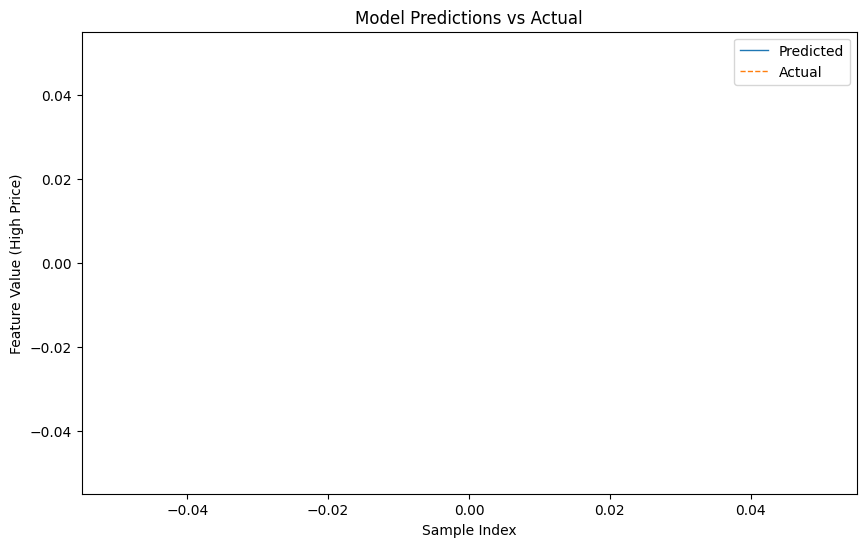

In [16]:
val_data_scaled = np.zeros_like(val_sequence)
for feature_idx in range(num_features):
    feature = val_sequence[:, :, feature_idx].reshape(-1, 1)  # Shape: (num_samples * seq_len, 1)
        
    val_data_scaled[:, :, feature_idx] = scalers[feature_idx].transform(feature).reshape(val_sequence.shape[0], -1)

val_data = val_data_scaled
val_dataset = TimeSeriesDataset(val_data)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

predictions, targets, loss = evaluate_model(model, val_loader)
print(f'Loss on val set: {loss:.8f}')
r2 = r2_score(targets, predictions)
print(f"R² Coefficient on Validation Set: {r2:.6f}")

window = 600
initial = 4500
plt.figure(figsize=(10, 6))
plt.plot(predictions[initial:initial+window], label="Predicted", linestyle="-", linewidth=1)
plt.plot(targets[initial:initial+window], label="Actual", linestyle="--", linewidth=1)
plt.title("Model Predictions vs Actual")
plt.xlabel("Sample Index")
plt.ylabel("Feature Value (High Price)")
plt.legend()
plt.show()

# Feeding Single Company + FinBERT sentiments

## Preprocessing

### Processing Data

In [17]:
news = pd.read_csv('data/bis_press_releases.csv')
news = news.dropna()
news['date'] = pd.to_datetime(news['date'], format='%d %b %Y')
news.sort_values(by='date', ascending=True, inplace=True)

In [18]:
prices = pd.read_csv('data/sp500_prices.csv')
prices['date'] = pd.to_datetime(prices['Date'])
prices = prices.drop(columns=['Date'])
prices.sort_values(by='date', ascending=True, inplace=True)

In [19]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

# Move the model to CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Get class labels
class_labels = model.config.id2label
prob_labels = model.config.label2id

# Example input text
text1 = news['content'].values[0]

inputs = tokenizer(text1, return_tensors="pt", truncation=True, padding=True)
inputs = {key: value.to(device) for key, value in inputs.items()}

# Perform inference
with torch.no_grad():  # No gradient calculation needed for predictions
    outputs = model(**inputs)

# Compute probabilities and predicted class
probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
predicted_class = torch.argmax(probs, dim=-1).item()

# Print the results
print("Predicted class:", class_labels[predicted_class])
print("Probabilities:", probs.cpu())  # Move probabilities back to CPU for printing
print('Labels assignation:', prob_labels)

Predicted class: positive
Probabilities: tensor([[0.4346, 0.1888, 0.3765]])
Labels assignation: {'positive': 0, 'negative': 1, 'neutral': 2}


In [20]:
def sentiment_labelling(df):
    """
    Perform sentiment labelling on the given DataFrame.
    Adds 'negative', 'neutral', and 'positive' columns to the DataFrame.
    Processes the DataFrame to group by date and fill missing values.
    """
    model.to(device)

    df['negative'] = 0.0
    df['neutral'] = 0.0
    df['positive'] = 0.0

    # Initialize the tqdm progress bar
    for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing Sentiment Analysis", dynamic_ncols=True):
        text = row['content']
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
        inputs = {key: value.to(device) for key, value in inputs.items()}  # Move inputs to CUDA
        with torch.no_grad():
            outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1).squeeze().tolist()
        df.at[index, 'positive'] = probs[0]
        df.at[index, 'negative'] = probs[1]
        df.at[index, 'neutral'] = probs[2]

    # Drop unnecessary columns
    if {'url', 'title', 'content'}.issubset(df.columns):
        df = df.drop(columns=['url', 'title', 'content'])

    # Group by date and calculate mean sentiment scores
    df = df.groupby("date").mean().reset_index()

    # Ensure the 'date' column is in datetime format
    df['date'] = pd.to_datetime(df['date'])

    # Create a full date range
    date_range = pd.date_range(start=df["date"].min(), end=df["date"].max())

    # Reindex to include all dates and forward-fill missing values
    df = df.set_index("date").reindex(date_range)
    df = df.fillna(method="ffill").reset_index()
    df.rename(columns={"index": "date"}, inplace=True)

    df = df.sort_values(by="date", ascending=True).reset_index(drop=True)

    return df

In [21]:
news = sentiment_labelling(news)

Processing Sentiment Analysis: 100%|██████████| 7061/7061 [02:58<00:00, 39.64it/s]


In [22]:
merged = pd.merge(prices, news, on='date', how='inner')
dates = merged['date'].drop_duplicates().values
split_date = dates[int(0.8 * len(dates))]

train = merged[merged['date'] <= split_date]
val = merged[merged['date'] > split_date]
num_val_dates = len(val['date'].drop_duplicates().values)

In [23]:
merged.head()

,Open,High,Low,Close,Volume,Company,date,negative,neutral,positive
0,34.093632,34.240608,33.826893,34.017422,2203665,EQT Corporation,2017-01-19,0.059217,0.592454,0.348329
1,39.119999,39.380001,39.099998,39.209999,12232400,Oracle Corporation,2017-01-19,0.059217,0.592454,0.348329
2,30.500000,30.830000,29.870001,29.959999,1065200,Trimble Inc.,2017-01-19,0.059217,0.592454,0.348329
3,69.370003,69.690002,69.250000,69.570000,1162100,Waste Management,2017-01-19,0.059217,0.592454,0.348329
4,36.070000,36.310001,35.930000,36.230000,2774500,Hormel Foods,2017-01-19,0.059217,0.592454,0.348329


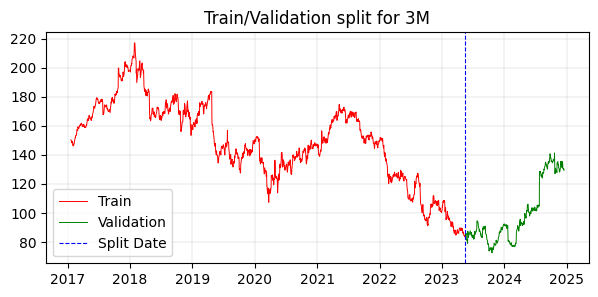

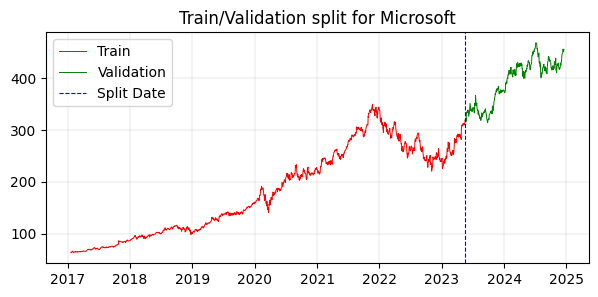

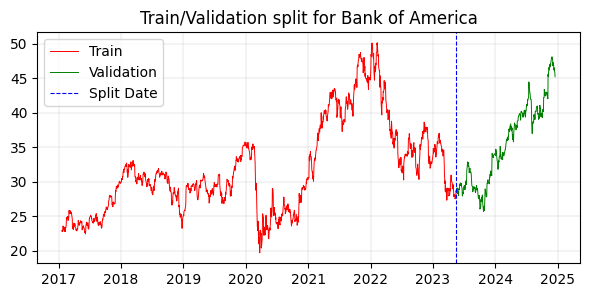

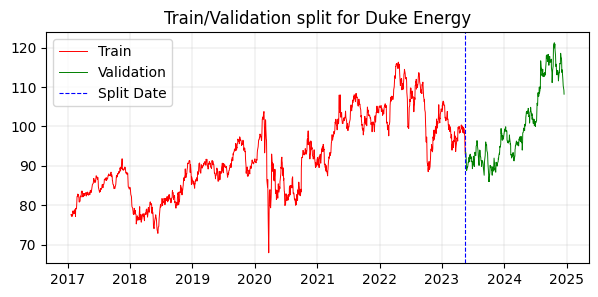

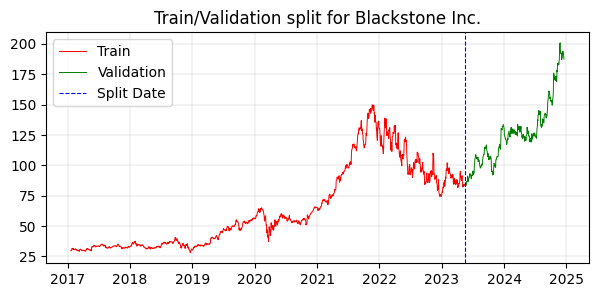

In [24]:
companies = prices['Company'].drop_duplicates().values
for company in companies[:5]:
    train_ex = train[train['Company'] == company]['High'].values
    train_dates = train['date'].drop_duplicates().values
    val_ex = val[val['Company'] == company]['High'].values
    val_dates = val['date'].drop_duplicates().values

    plt.figure(figsize=(7, 3))
    plt.grid(linewidth=0.2)
    plt.plot(train_dates, train_ex, linewidth=0.7, label='Train', c='r')
    plt.plot(val_dates, val_ex, linewidth=0.7, label='Validation', c='g')
    plt.axvline(x=split_date, color='b', linestyle='--', linewidth=0.8, label='Split Date')
    plt.legend()
    plt.title(f'Train/Validation split for {company}')
plt.show()

### Data Augmentation

In [25]:
train_sequence = sequencing(train, companies[:num_companies], 100, include_news=True)
val_sequence = sequencing(val, companies[:num_companies], num_val_dates - 1, include_news=True)

## Training

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_data, test_data = train_test_split(train_sequence, test_size=0.2, random_state=42, shuffle=True)
train_data = np.array(train_data)
test_data = np.array(test_data)

num_features = train_data.shape[2]  # Number of features
scalers = [StandardScaler() for _ in range(num_features)]

train_data_scaled = np.zeros_like(train_data)
test_data_scaled = np.zeros_like(test_data)

for feature_idx in range(num_features):
    train_feature = train_data[:, :, feature_idx].reshape(-1, 1)  # Shape: (num_samples * seq_len, 1)
    test_feature = test_data[:, :, feature_idx].reshape(-1, 1)
    
    scalers[feature_idx].fit(train_feature)
    
    train_data_scaled[:, :, feature_idx] = scalers[feature_idx].transform(train_feature).reshape(train_data.shape[0], -1)
    test_data_scaled[:, :, feature_idx] = scalers[feature_idx].transform(test_feature).reshape(test_data.shape[0], -1)

train_data = train_data_scaled
test_data = test_data_scaled

train_dataset = TimeSeriesDataset(train_data)
test_dataset = TimeSeriesDataset(test_data)

generator = torch.Generator()
generator.manual_seed(42)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, generator=generator)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, generator=generator)

input_dim = train_data.shape[2]
hidden_dim = 256
num_layers = 4
output_dim = 1

learning_rate = 0.01
dropout = 0.2
weight_decay = 1e-4

num_epochs = 256

model = LSTM(input_dim, hidden_dim, num_layers, output_dim).to(device)
early_stopping = EarlyStopping(patience=32)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
steps_per_epoch = len(train_loader)  # Total number of batches in one epoch
scheduler = OneCycleLR(
    optimizer,
    max_lr=learning_rate,
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch
)

print('Model defined, start training ...')
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        # Forward pass
        outputs = model(x_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        train_loss += loss.item()
    
    # Testing loop
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            test_outputs = model(x_test)
            loss = criterion(test_outputs.squeeze(), y_test)
            test_loss += loss.item()
    
    # Print metrics
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.8f}, "
          f"Test Loss: {test_loss/len(test_loader):.8f}, LR: {scheduler.get_last_lr()[0]:.6f}")
    
    early_stopping(test_loss, model)
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}.")
        break

Model defined, start training ...
Epoch [1/256], Train Loss: 0.07644656, Test Loss: 0.00622341, LR: 0.000404
Validation loss improved. Model saved to best_model.pth
Epoch [2/256], Train Loss: 0.00591697, Test Loss: 0.00523941, LR: 0.000416
Validation loss improved. Model saved to best_model.pth
Epoch [3/256], Train Loss: 0.00570371, Test Loss: 0.00428323, LR: 0.000436
Validation loss improved. Model saved to best_model.pth
Epoch [4/256], Train Loss: 0.00493103, Test Loss: 0.00408680, LR: 0.000464
Validation loss improved. Model saved to best_model.pth
Epoch [5/256], Train Loss: 0.00422269, Test Loss: 0.00459271, LR: 0.000500
EarlyStopping counter: 1 out of 32
Epoch [6/256], Train Loss: 0.00442496, Test Loss: 0.00438524, LR: 0.000544
EarlyStopping counter: 2 out of 32
Epoch [7/256], Train Loss: 0.00383071, Test Loss: 0.00389209, LR: 0.000595
Validation loss improved. Model saved to best_model.pth
Epoch [8/256], Train Loss: 0.00406693, Test Loss: 0.00347980, LR: 0.000655
Validation loss 

## Result

### Reload Model

In [27]:
model = LSTM(input_dim, hidden_dim, num_layers, output_dim).to(device)
model.load_state_dict(torch.load('best_model.pth'))

C:\Users\mcgpr\AppData\Local\Temp/ipykernel_17152/359333540.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


<All keys matched successfully>

### Test Set

In [28]:
# Evaluate on test set
predictions, targets, loss = evaluate_model(model, test_loader)
print(f'Loss on test set: {loss:.8f}')
r2 = r2_score(targets, predictions)
print(f"R² Coefficient on Test Set: {r2:.4f}")

Loss on test set: 0.02232064
R² Coefficient on Test Set: 0.9986


### Validation Set

Loss on val set: 0.00047491
R² Coefficient on Validation Set: 0.981508


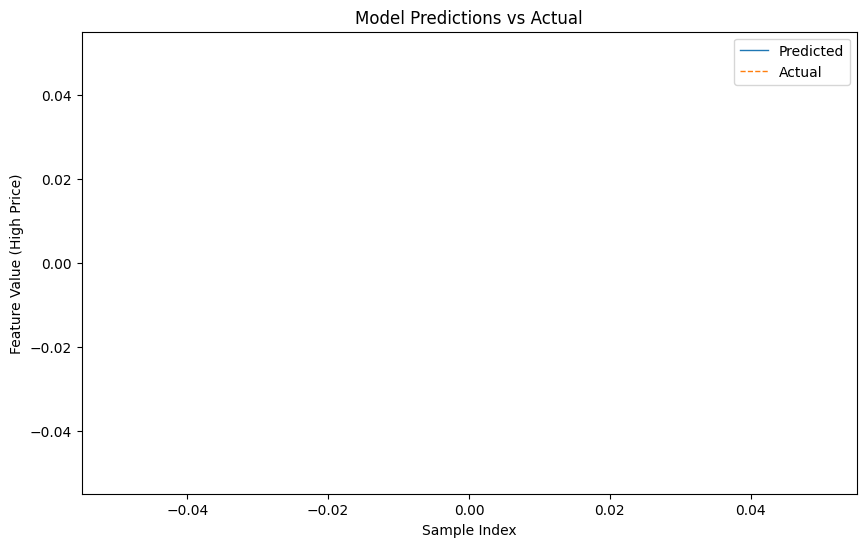

In [29]:
val_data_scaled = np.zeros_like(val_sequence)
for feature_idx in range(num_features):
    feature = val_sequence[:, :, feature_idx].reshape(-1, 1)  # Shape: (num_samples * seq_len, 1)
        
    val_data_scaled[:, :, feature_idx] = scalers[feature_idx].transform(feature).reshape(val_sequence.shape[0], -1)

val_data = val_data_scaled
val_dataset = TimeSeriesDataset(val_data)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

predictions, targets, loss = evaluate_model(model, val_loader)
print(f'Loss on val set: {loss:.8f}')
r2 = r2_score(targets, predictions)
print(f"R² Coefficient on Validation Set: {r2:.6f}")

window = 600
initial = 4500
plt.figure(figsize=(10, 6))
plt.plot(predictions[initial:initial+window], label="Predicted", linestyle="-", linewidth=1)
plt.plot(targets[initial:initial+window], label="Actual", linestyle="--", linewidth=1)
plt.title("Model Predictions vs Actual")
plt.xlabel("Sample Index")
plt.ylabel("Feature Value (High Price)")
plt.legend()
plt.show()

# Feeding Single Company + sentiments

## Preprocessing

### Data Processing

In [30]:
news = pd.read_csv('data/bis_press_releases.csv')
news = news.dropna()
news['date'] = pd.to_datetime(news['date'], format='%d %b %Y')
news.sort_values(by='date', ascending=True, inplace=True)

In [31]:
prices = pd.read_csv('data/sp500_prices.csv')
prices['date'] = pd.to_datetime(prices['Date'])
prices = prices.drop(columns=['Date'])
prices.sort_values(by='date', ascending=True, inplace=True)

In [32]:
from datasets import load_loughran_mcdonald_dictionary

In [33]:
lm = load_loughran_mcdonald_dictionary()

INFO:datasets:Loading from cache file: data\Loughran-McDonald_MasterDictionary_1993-2023.csv


In [34]:
def sentiment_labelling(df, lm, column):
    """
    Perform sentiment labelling on the given DataFrame.
    Adds 'negative', 'neutral', and 'positive' columns to the DataFrame.
    Processes the DataFrame to group by date and fill missing values.
    """
    # Initialize sentiment columns
    # Extract the text column
    X = df[column]
    
    # Define sentiment functions
    funcs = {
        "negative": lambda x: x.Negative > 0,
        "positive": lambda x: x.Positive > 0,
        "all": lambda x: x.Word.notna(),
    }

    # Helper function to compute total count for a specific sentiment
    def get_total_count(X, lm, func):
        m = CountVectorizer(vocabulary=lm.loc[func].Word.str.lower().values)
        return pd.DataFrame(m.fit_transform(X).toarray(), index=X.index).sum(axis=1)

    # Compute sentiment counts for each sentiment category
    lm_counts = pd.concat({k: get_total_count(X, lm, v) for k, v in funcs.items()}, axis=1)

    sentiment_columns = ["negative", "positive"]
    lm_counts[sentiment_columns] = lm_counts[sentiment_columns].div(lm_counts[sentiment_columns].sum(axis=1), axis=0)

    lm_counts.drop(columns=["all"], inplace=True)

    if 'date' in df.columns:
        lm_counts['date'] = df['date'].values

    lm_counts.reset_index(drop=True, inplace=True)

    if {'url', 'title', 'content'}.issubset(df.columns):
        df = df.drop(columns=['url', 'title', 'content'])

    lm_counts = lm_counts.groupby("date").mean().reset_index()

    lm_counts['date'] = pd.to_datetime(lm_counts['date'])

    date_range = pd.date_range(start=lm_counts["date"].min(), end=lm_counts["date"].max())

    lm_counts = lm_counts.set_index("date").reindex(date_range)
    lm_counts = lm_counts.fillna(method="ffill").reset_index()
    lm_counts.rename(columns={"index": "date"}, inplace=True)

    lm_counts = lm_counts.sort_values(by="date", ascending=True).reset_index(drop=True)

    return lm_counts

In [35]:
news = sentiment_labelling(news, lm, 'content')

In [36]:
merged = pd.merge(prices, news, on='date', how='inner')
dates = merged['date'].drop_duplicates().values
split_date = dates[int(0.8 * len(dates))]

train = merged[merged['date'] <= split_date]
val = merged[merged['date'] > split_date]
num_val_dates = len(val['date'].drop_duplicates().values)

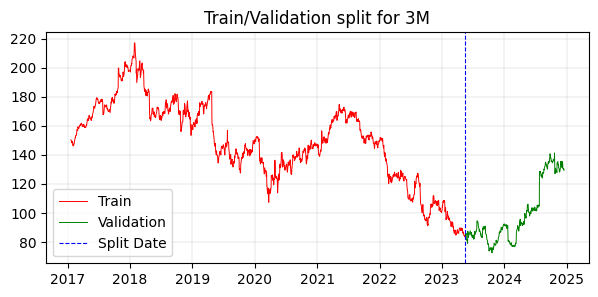

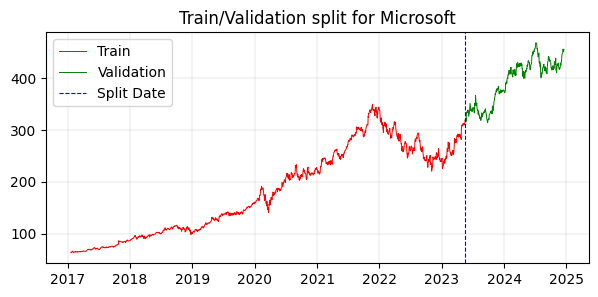

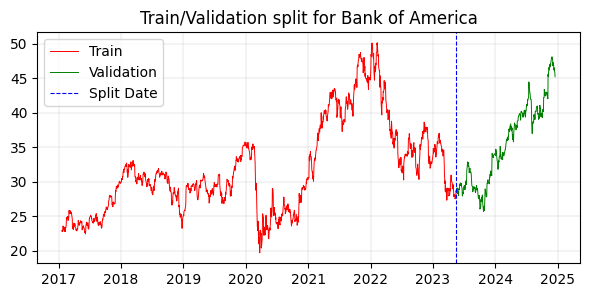

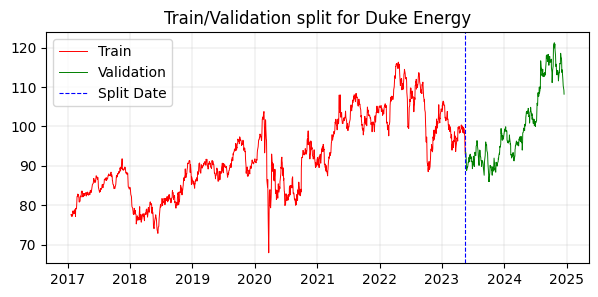

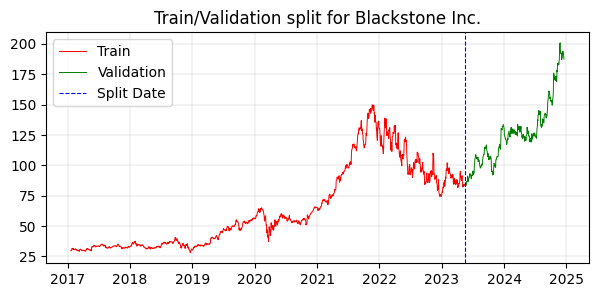

In [37]:
companies = prices['Company'].drop_duplicates().values
for company in companies[:5]:
    train_ex = train[train['Company'] == company]['High'].values
    train_dates = train['date'].drop_duplicates().values
    val_ex = val[val['Company'] == company]['High'].values
    val_dates = val['date'].drop_duplicates().values

    plt.figure(figsize=(7, 3))
    plt.grid(linewidth=0.2)
    plt.plot(train_dates, train_ex, linewidth=0.7, label='Train', c='r')
    plt.plot(val_dates, val_ex, linewidth=0.7, label='Validation', c='g')
    plt.axvline(x=split_date, color='b', linestyle='--', linewidth=0.8, label='Split Date')
    plt.legend()
    plt.title(f'Train/Validation split for {company}')
plt.show()

In [38]:
merged.head(480)

,Open,High,Low,Close,Volume,Company,date,negative,positive
0,34.093632,34.240608,33.826893,34.017422,2203665,EQT Corporation,2017-01-19,0.473718,0.526282
1,39.119999,39.380001,39.099998,39.209999,12232400,Oracle Corporation,2017-01-19,0.473718,0.526282
2,30.500000,30.830000,29.870001,29.959999,1065200,Trimble Inc.,2017-01-19,0.473718,0.526282
3,69.370003,69.690002,69.250000,69.570000,1162100,Waste Management,2017-01-19,0.473718,0.526282
4,36.070000,36.310001,35.930000,36.230000,2774500,Hormel Foods,2017-01-19,0.473718,0.526282
...,...,...,...,...,...,...,...,...,...
475,26.410000,26.600000,25.969999,25.990000,5618400,Fifth Third Bancorp,2017-01-19,0.473718,0.526282
476,71.888298,72.074471,71.125885,71.453903,3305153,Danaher Corporation,2017-01-19,0.473718,0.526282
477,12.400000,12.560000,12.340000,12.430000,30135600,Ford Motor Company,2017-01-19,0.473718,0.526282
478,40.345501,40.345501,40.084499,40.250999,33400000,Alphabet Inc. (Class C),2017-01-20,0.373975,0.626025


### Data Augmentation

In [39]:
train_sequence = sequencing(train, companies[:num_companies], 100, include_news=True)
val_sequence = sequencing(val, companies[:num_companies], num_val_dates - 1, include_news=True)

## Training

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_data, test_data = train_test_split(train_sequence, test_size=0.2, random_state=42, shuffle=True)
train_data = np.array(train_data)
test_data = np.array(test_data)

num_features = train_data.shape[2]  # Number of features
scalers = [StandardScaler() for _ in range(num_features)]

train_data_scaled = np.zeros_like(train_data)
test_data_scaled = np.zeros_like(test_data)

for feature_idx in range(num_features):
    train_feature = train_data[:, :, feature_idx].reshape(-1, 1)  # Shape: (num_samples * seq_len, 1)
    test_feature = test_data[:, :, feature_idx].reshape(-1, 1)
    
    scalers[feature_idx].fit(train_feature)
    
    train_data_scaled[:, :, feature_idx] = scalers[feature_idx].transform(train_feature).reshape(train_data.shape[0], -1)
    test_data_scaled[:, :, feature_idx] = scalers[feature_idx].transform(test_feature).reshape(test_data.shape[0], -1)

train_data = train_data_scaled
test_data = test_data_scaled

train_dataset = TimeSeriesDataset(train_data)
test_dataset = TimeSeriesDataset(test_data)

generator = torch.Generator()
generator.manual_seed(42)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, generator=generator)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, generator=generator)

input_dim = train_data.shape[2]
hidden_dim = 256
num_layers = 4
output_dim = 1

learning_rate = 0.01
dropout = 0.2
weight_decay = 1e-4

num_epochs = 256

model = LSTM(input_dim, hidden_dim, num_layers, output_dim).to(device)
early_stopping = EarlyStopping(patience=32)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
steps_per_epoch = len(train_loader)  # Total number of batches in one epoch
scheduler = OneCycleLR(
    optimizer,
    max_lr=learning_rate,
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch
)

print('Model defined, start training ...')
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        # Forward pass
        outputs = model(x_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        train_loss += loss.item()
    
    # Testing loop
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            test_outputs = model(x_test)
            loss = criterion(test_outputs.squeeze(), y_test)
            test_loss += loss.item()
    
    # Print metrics
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.8f}, "
          f"Test Loss: {test_loss/len(test_loader):.8f}, LR: {scheduler.get_last_lr()[0]:.6f}")
    
    early_stopping(test_loss, model)
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}.")
        break

Model defined, start training ...
Epoch [1/256], Train Loss: 0.06659996, Test Loss: 0.00661523, LR: 0.000404
Validation loss improved. Model saved to best_model.pth
Epoch [2/256], Train Loss: 0.00603679, Test Loss: 0.00630669, LR: 0.000416
Validation loss improved. Model saved to best_model.pth
Epoch [3/256], Train Loss: 0.00551709, Test Loss: 0.00401106, LR: 0.000436
Validation loss improved. Model saved to best_model.pth
Epoch [4/256], Train Loss: 0.00491657, Test Loss: 0.00485867, LR: 0.000464
EarlyStopping counter: 1 out of 32
Epoch [5/256], Train Loss: 0.00415974, Test Loss: 0.00364170, LR: 0.000500
Validation loss improved. Model saved to best_model.pth
Epoch [6/256], Train Loss: 0.00397506, Test Loss: 0.00585871, LR: 0.000544
EarlyStopping counter: 1 out of 32
Epoch [7/256], Train Loss: 0.00370664, Test Loss: 0.00365350, LR: 0.000595
EarlyStopping counter: 2 out of 32
Epoch [8/256], Train Loss: 0.00385509, Test Loss: 0.00343252, LR: 0.000655
Validation loss improved. Model saved

## Result

### Reload

In [41]:
model = LSTM(input_dim, hidden_dim, num_layers, output_dim).to(device)
model.load_state_dict(torch.load('best_model.pth'))

C:\Users\mcgpr\AppData\Local\Temp/ipykernel_17152/359333540.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


<All keys matched successfully>

### Test Set

In [42]:
# Evaluate on test set
predictions, targets, loss = evaluate_model(model, test_loader)
print(f'Loss on test set: {loss:.8f}')
r2 = r2_score(targets, predictions)
print(f"R² Coefficient on Test Set: {r2:.4f}")

Loss on test set: 0.01511675
R² Coefficient on Test Set: 0.9985


### Validation Set

Loss on val set: 0.00032163
R² Coefficient on Validation Set: 0.969135


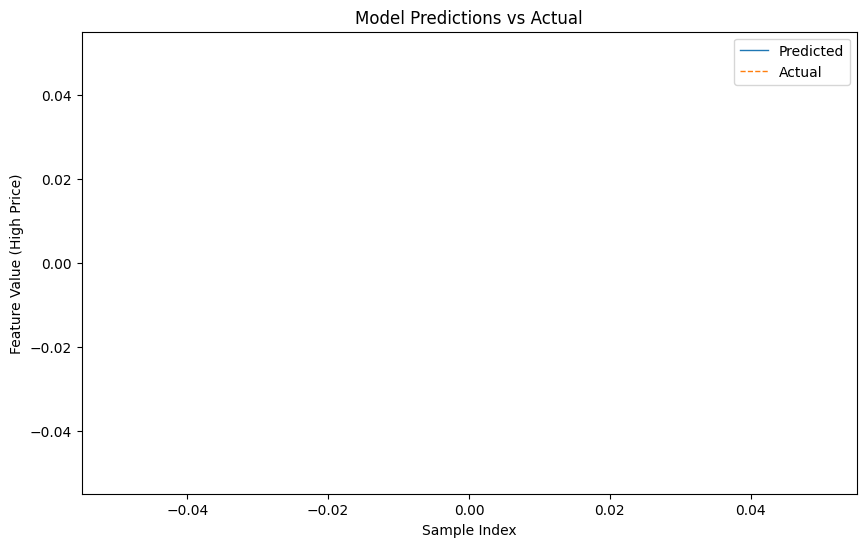

In [43]:
val_data_scaled = np.zeros_like(val_sequence)
for feature_idx in range(num_features):
    feature = val_sequence[:, :, feature_idx].reshape(-1, 1)  # Shape: (num_samples * seq_len, 1)
        
    val_data_scaled[:, :, feature_idx] = scalers[feature_idx].transform(feature).reshape(val_sequence.shape[0], -1)

val_data = val_data_scaled
val_dataset = TimeSeriesDataset(val_data)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

predictions, targets, loss = evaluate_model(model, val_loader)
print(f'Loss on val set: {loss:.8f}')
r2 = r2_score(targets, predictions)
print(f"R² Coefficient on Validation Set: {r2:.6f}")

window = 600
initial = 4500
plt.figure(figsize=(10, 6))
plt.plot(predictions[initial:initial+window], label="Predicted", linestyle="-", linewidth=1)
plt.plot(targets[initial:initial+window], label="Actual", linestyle="--", linewidth=1)
plt.title("Model Predictions vs Actual")
plt.xlabel("Sample Index")
plt.ylabel("Feature Value (High Price)")
plt.legend()
plt.show()